In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../core/output/batters.csv')
indexer = df.reset_index()[['index', 'retroID']].to_dict()['retroID']
y = df['Batting'].values
to_drop = ['debutYear', 'finalYear', 'G', '1B', 'AB', 'RBI', 'wOBA']
df.drop(columns=to_drop, inplace=True)

In [3]:
df

,retroID,weight,height,pos_1B,pos_2B,pos_3B,pos_C,pos_OF,pos_P,pos_SS,...,SO,IBB,HBP,SH,SF,GIDP,NL,wRC+,WAR,Batting
0,aardd001,0.569672,0.60,0,0,0,0,0,1,0,...,2,0,0,1,0,0,1,-100,-0.1,0.000358
1,aaroh101,0.426230,0.45,0,0,0,0,1,0,0,...,1383,293,32,21,121,328,1,153,136.3,0.350195
2,aarot101,0.467213,0.60,1,0,0,0,0,0,0,...,145,3,0,9,6,36,1,76,-1.7,0.157131
3,aased001,0.467213,0.60,0,0,0,0,0,1,0,...,3,0,0,0,0,0,1,-100,-0.1,0.000358
4,abada001,0.442623,0.50,1,0,0,0,0,0,0,...,5,0,0,0,0,1,1,0,-0.4,0.090001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15288,zupcb001,0.590164,0.65,0,0,0,0,1,0,0,...,137,3,6,20,8,15,0,74,-0.9,0.156062
15289,zupof101,0.434426,0.40,0,0,0,1,0,0,0,...,6,0,0,0,0,0,0,37,-0.2,0.123425
15290,zuveg101,0.487705,0.65,0,0,0,0,0,1,0,...,39,0,0,16,0,3,1,0,-0.3,0.090088
15291,zuvep001,0.397541,0.45,0,0,0,0,0,0,1,...,50,1,2,18,0,8,1,52,-2.2,0.135118


<h2>Building the Model</h2>

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X = df.drop(columns=['Batting']).values
y = df[['retroID', 'Batting']].values

<p>When we do our train-test split, since it's random in how it splits up the data, we need to keep track of the appropriate keys (retro IDs) for each data point.</p>

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train_keys = np.asarray([x[0] for x in X_train])
X_train = np.asarray([x[1:] for x in X_train])
X_test_keys = np.asarray([x[0] for x in X_test])
X_test = np.asarray([x[1:] for x in X_test])
y_train_keys = np.asarray([y[0] for y in y_train])
y_train = np.asarray([y[1] for y in y_train])
y_test_keys = np.asarray([y[0] for y in y_test])
y_test = np.asarray([y[1] for y in y_test])

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

In [8]:
X_train.shape

(12234, 29)

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
def to_tensor_input(player):
    return scaler.transform(player.values.reshape(-1,29))[0]

In [12]:
tensor = df.drop(columns=['retroID', 'Batting'])
player_tensor_inputs = tensor.apply(lambda player: to_tensor_input(player), axis=1)

In [13]:
player_tensor_inputs

0        [0.5696720000000001, 0.6, 0.0, 0.0, 0.0, 0.0, ...
1        [0.42623, 0.45, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
2        [0.467213, 0.6, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.467213, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
4        [0.44262299999999993, 0.5, 1.0, 0.0, 0.0, 0.0,...
                               ...                        
15288    [0.590164, 0.65, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...
15289    [0.43442600000000003, 0.4, 0.0, 0.0, 0.0, 1.0,...
15290    [0.487705, 0.65, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...
15291    [0.397541, 0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
15292    [0.467213, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
Length: 15293, dtype: object

In [14]:
tensor = pd.DataFrame(player_tensor_inputs.values.tolist())

In [15]:
tensor.to_csv('../core/tensors/t_batting.csv', index=False, float_format='%g')

In [16]:
epochs = 400
batch_size = 64
loss_param = 'mse'
optimizer_param = 'adam'
stop_monitor = 'val_loss'
stop_patience = 20

In [18]:
model = Sequential()

model.add(Dense(116, activation='relu', kernel_regularizer=regularizers.l2(0.0001), input_shape= X_train.shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(232, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.5))

model.add(Dense(116, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss=loss_param, optimizer=optimizer_param)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
early_stop = EarlyStopping(monitor=stop_monitor, patience=stop_patience)

In [21]:
results = model.fit(x=X_train, y=y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stop]
                    )

Train on 12234 samples, validate on 3059 samples
Epoch 1/400
12234/12234 [==============================] - 1s 98us/sample - loss: 0.0342 - val_loss: 0.0174
Epoch 2/400
12234/12234 [==============================] - 1s 43us/sample - loss: 0.0141 - val_loss: 0.0084
Epoch 3/400
12234/12234 [==============================] - 0s 39us/sample - loss: 0.0076 - val_loss: 0.0046
Epoch 4/400
12234/12234 [==============================] - 0s 39us/sample - loss: 0.0050 - val_loss: 0.0031
Epoch 5/400
12234/12234 [==============================] - 0s 39us/sample - loss: 0.0038 - val_loss: 0.0024
Epoch 6/400
12234/12234 [==============================] - 0s 40us/sample - loss: 0.0031 - val_loss: 0.0020
Epoch 7/400
12234/12234 [==============================] - 0s 40us/sample - loss: 0.0028 - val_loss: 0.0018
Epoch 8/400
12234/12234 [==============================] - 1s 41us/sample - loss: 0.0027 - val_loss: 0.0017
Epoch 9/400
12234/12234 [==============================] - 1s 51us/sample - loss: 0.002

In [90]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             multiple                  3480      
_________________________________________________________________
dropout_50 (Dropout)         multiple                  0         
_________________________________________________________________
dense_61 (Dense)             multiple                  27144     
_________________________________________________________________
dropout_51 (Dropout)         multiple                  0         
_________________________________________________________________
dense_62 (Dense)             multiple                  27028     
_________________________________________________________________
dropout_52 (Dropout)         multiple                  0         
_________________________________________________________________
dense_63 (Dense)             multiple                

In [28]:
import os

In [29]:
losses = model.history.history
losses['loss'] = np.asarray(losses['loss'])
losses['val_loss'] = np.asarray(losses['val_loss'])
final_number_of_epochs = len(losses['loss'])
min_loss = losses['loss'].min()
mean_loss = losses['loss'].mean()
final_loss = losses['loss'][-1]
min_val_loss = losses['val_loss'].min()
mean_val_loss = losses['val_loss'].mean()
final_val_loss = losses['val_loss'][-1]

def get_model_summary():
    output = []
    model.summary(print_fn=lambda line: output.append(line))
    return str(output).strip('[]')

summary = get_model_summary()

record = {
    'Epochs': final_number_of_epochs,
    'Batch_Size': batch_size,
    'Loss_Func': loss_param,
    'Optimizer': optimizer_param,
    'Early_Stop_Monitor': stop_monitor,
    'Early_Stop_Patience': stop_patience,
    'Min_Loss': min_loss,
    'Mean_Loss': mean_loss,
    'Final_Loss': final_loss,
    'Min_Val_Loss': min_val_loss,
    'Mean_Val_Loss': mean_val_loss,
    'Final_Val_Loss': final_val_loss,
    'Model': summary
}

new_data = pd.DataFrame(record, index=[0])

if os.path.exists('../core/records/batting_results.csv'):
    df_records = pd.read_csv('../core/records/batting_results.csv')
    df_records = df_records.append(new_data)
else:
    df_records = pd.DataFrame(new_data)
    
df_records.to_csv('../core/records/batting_results.csv', index=False, float_format='%g')

<h2>Model Evaluation</h2>

In [25]:
losses = pd.DataFrame(model.history.history)

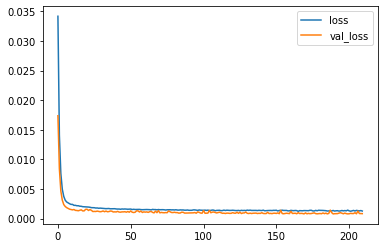

In [26]:
losses.plot()

In [61]:
predictions = model.predict(X_test)
predictions = [pred for sublist in predictions for pred in sublist]

In [29]:
test_player_ratings = dict(zip(X_test_keys, predictions))

In [30]:
player_key = df['retroID']

In [31]:
player_key

0        aardd001
1        aaroh101
2        aarot101
3        aased001
4        abada001
           ...   
15288    zupcb001
15289    zupof101
15290    zuveg101
15291    zuvep001
15292    zycht001
Name: retroID, Length: 15293, dtype: object

In [32]:
results = model.predict(tensor.to_numpy())

In [33]:
len(results)

15293

In [34]:
results.mean()

0.11595928

In [35]:
df['Batting'].shape

(15293,)

In [36]:
results.shape

(15293, 1)

In [37]:
results = [pred for sublist in results for pred in sublist]

In [38]:
diff = df['Batting'] - results

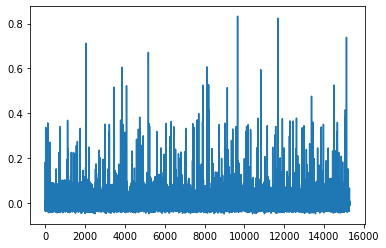

In [39]:
diff.plot()

In [40]:
diff.mean()

0.005629653826018003

In [24]:
model.save('../core/models/model_batting.h5')